# \#NetNeutrality

# Import Data

In [329]:
import EDA as eda

sns.set(color_codes = True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
mega_df[mega_df['text'] > '2017-12-14 00:00:00']

,fullname,id,likes,replies,retweets,text,timestamp,url,user
413866,Gilien the Noble,941453421722439680,0,0,0,"I wonder, if Congress puts a stop to the end o...",2017-12-14 23:42:41,/Gilien2018/status/941453421722439680,Gilien2018
413867,9ToeHavin'est,941453422057816064,0,0,0,Eat & @AjitPaiFCC #NetNeutrality,2017-12-14 23:42:41,/KissMyEntireAzz/status/941453422057816064,KissMyEntireAzz
413868,Celena Brosseau,941453422305345536,0,0,0,"#NetNeutrality is key to free expression, inno...",2017-12-14 23:42:41,/CelenaBrosseau/status/941453422305345536,CelenaBrosseau
413869,Twitchy Team,941453422582263808,24,0,14,APOCALYPSE NOW! Ben Shapiro's #NetNeutrality t...,2017-12-14 23:42:41,/TwitchyTeam/status/941453422582263808,TwitchyTeam
413870,yulbiz,941453423819575296,0,0,0,RT @hainsworthtv: Canada’s telcos want to scra...,2017-12-14 23:42:42,/yulbiz/status/941453423819575298,yulbiz
413871,Antonio Saccomanno,941453423840342016,0,0,0,"#NetNeutrality is key to free expression, inno...",2017-12-14 23:42:42,/AntoS_Italia17/status/941453423840342016,AntoS_Italia17
413872,Barry Ryan 🌐,941453426940153856,0,0,0,"#NetNeutrality is key to free expression, inno...",2017-12-14 23:42:42,/Its_Spunky/status/941453426940153856,Its_Spunky
413873,posh,941453427770404864,1,0,0,"#NetNeutrality is key to free expression, inno...",2017-12-14 23:42:43,/cele1357/status/941453427770404865,cele1357
413874,rum ham,941453428554977280,1,0,0,"#NetNeutrality is key to free expression, inno...",2017-12-14 23:42:43,/SoWrongItsCoop/status/941453428554977280,SoWrongItsCoop
413875,C. Conniff,941453429670535168,0,0,0,Translation: Fuck you @AjitPaiFCC #NetNeutrali...,2017-12-14 23:42:43,/CConniff85/status/941453429670535168,CConniff85


In [ ]:
mega_df.describe()

# Data Cleaning

In [255]:
# This creates new columns for hashtags (other than #netneutrality), links, and mentions in the tweet data.
# It also creates a field for text without links since the same tweets with slightly different URLs keep
# coming up.

mega_df["other_hashtags"] = mega_df["text"].apply(eda.get_hashtags)
mega_df["links"] = mega_df["text"].apply(eda.get_links)
mega_df["@s"] = mega_df["text"].apply(eda.get_mentions)
mega_df['cleaned_text'] = mega_df['text'].apply(eda.clean_text)

In [ ]:
d = {'text': ['oh wow @tyler sucks', '@!$ is that', 'hey@234tjeld fuk', '@', "suck @fcc's dick"]}
test_df = pd.DataFrame(data=d)
test_df

In [ ]:
test_df["@s"] = test_df["text"].apply(eda.get_mentions)
test_df

## Identifying guided information campaigns

In [89]:
# Create Counter that will tally up the number of times text appears in tweets

tweet_text_dict = eda.tweet_text_dict_fn(mega_df)

In [90]:
campaign_tweet_set = eda.create_campaign_tweet_set(tweet_text_dict)
original_tweet_set = eda.create_original_tweet_set(tweet_text_dict)

In [91]:
def info_campaign(text):
    if text in campaign_tweet_set:
        return 1
    else:
        return 0

In [92]:
def original_tweet(text):
    if text in original_tweet_set:
        return 1
    else:
        return 0

In [256]:
# Create new columns using above functions

mega_df['info_campaign'] = mega_df['cleaned_text'].apply(info_campaign)
mega_df['original_tweet'] = mega_df['cleaned_text'].apply(original_tweet)

In [321]:
mega_df[mega_df[a]

,fullname,id,likes,replies,retweets,text,timestamp,url,user,other_hashtags,links,@s,cleaned_text,info_campaign,original_tweet,pro_repeal
353905,Donna Goode,941036309845626880,0,0,0,"#NetNeutrality is key to free expression, inno...",2017-12-13 20:05:14,/goodedonnae/status/941036309845626883,goodedonnae,[],[https://cards.twitter.com/cards/18ce54j487s/5...,[],is key to free expression innovation public s...,1,0,0
330152,Hilary Bovay,941005322851889152,0,0,0,"@SenRobPortman, I'm a constituent & #netneutra...",2017-12-13 18:02:06,/hilarybovay/status/941005322851889152,hilarybovay,[],[],[],im a constituent rules matter to me please op...,1,0,0
304340,Lateef,940721858843938816,0,0,0,Save Net Neutrality #netneutrality - Sign the ...,2017-12-12 23:15:43,/Teefszn/status/940721858843938816,Teefszn,[],[http://chn.ge/2bemiue],[@change],save net neutrality sign the petition via,1,0,0
40574,dino olivas,936578526525788160,0,0,0,The internet as we know it may soon be a thing...,2017-12-01 12:51:36,/dino661/status/936578526525788160,dino661,[],[https://now.justicedemocrats.com/petition/net...,[],the internet as we know it may soon be a thing...,1,0,0
13079,(((Anna))),935622607432552448,0,0,0,#NetNeutrality https://twitter.com/AdamSchiffC...,2017-11-28 21:33:07,/TallyAnnaE/status/935622607432552450,TallyAnnaE,[],[https://twitter.com/adamschiffca/status/93304...,[],…,1,0,0
325564,Aria,940999140015857664,0,0,0,The @FCC should stand up for the consumers it ...,2017-12-13 17:37:32,/arillusine/status/940999140015857664,arillusine,[],[https://cards.twitter.com/cards/18ce54j487s/5...,[@fcc],the should stand up for the consumers it repre...,1,0,0
144439,imani,938575467367497728,2,0,0,Save Net Neutrality #netneutrality - Sign the ...,2017-12-07 01:06:43,/childishmannii/status/938575467367497730,childishmannii,[],[http://chn.ge/2ks4yts],[@change],save net neutrality sign the petition via,1,0,0
326351,Zackary Bennett,941000213308854272,0,0,0,The @FCC should stand up for the consumers it ...,2017-12-13 17:41:48,/ChromeDragster/status/941000213308854273,ChromeDragster,[],[https://cards.twitter.com/cards/18ce54j487s/5...,[@fcc],the should stand up for the consumers it repre...,1,0,0
146604,Lily Scheid,938629489839493120,2,0,2,What\n\n if\n\n the\n\n Internet\n\n was\n\n s...,2017-12-07 04:41:23,/Lily_Lou_2468/status/938629489839493120,Lily_Lou_2468,[],[https://www.battleforthenet.com],[],what if the internet was so slow it loaded one...,1,0,0
96265,Hat of Foil,938149958489960448,0,0,0,The former Verizon lawyer in charge of the FCC...,2017-12-05 20:55:54,/hatoffoil/status/938149958489960448,hatoffoil,[],[http://verizonprotests.com],[],the former verizon lawyer in charge of the fcc...,1,0,0


## Get to work seeing if there are any tweets in here that appear to be pro-repeal of net neutrality

In [258]:
# Function to be used in apply - labels tweets that appear to be pro-repeal of net neutrality

mega_df['pro_repeal'] = mega_df['other_hashtags'].apply(eda.negative_tweet_grab)

In [259]:
# Create array of usernames that were classified as 'pro-repeal'

pro_repeal_users = mega_df['user'][mega_df['pro_repeal'] == 1]
pro_repeal_users_unique = mega_df['user'][mega_df['pro_repeal'] == 1].unique()

## Ok, now let's split the data into 3 categories:
### * Guided information campaign tweets
### * Original tweets (only showed up one time)
### * Tweets that appear to be pro-repeal of net neutrality that still used #netneutrality 

In [260]:
campaign_tweets_df = mega_df[(mega_df['info_campaign'] == 1)]
original_tweets_df = mega_df[(mega_df['original_tweet'] == 1) & (mega_df['pro_repeal'] == 0)]

# All of the tweets in this category are determined to be original - there were not any that were classified as \
# pro-repeal and part of an information campaign. The total number of pro-repeal tweets is low.
repeal_tweets_df = mega_df[(mega_df['pro_repeal'] == 1) & (mega_df['original_tweet'] == 1)]

In [ ]:
original_total = mega_df['fullname'].count()
new_total = (campaign_tweets_df['fullname'].count()) + (original_tweets_df['fullname'].count()) + \
(repeal_tweets_df['fullname'].count())

# This removed a total of 7.72% of my data since I was not confident in how to classify it as an information campaign
# or original tweet.
print(((original_total - new_total) / original_total) * 100)

## Some EDA

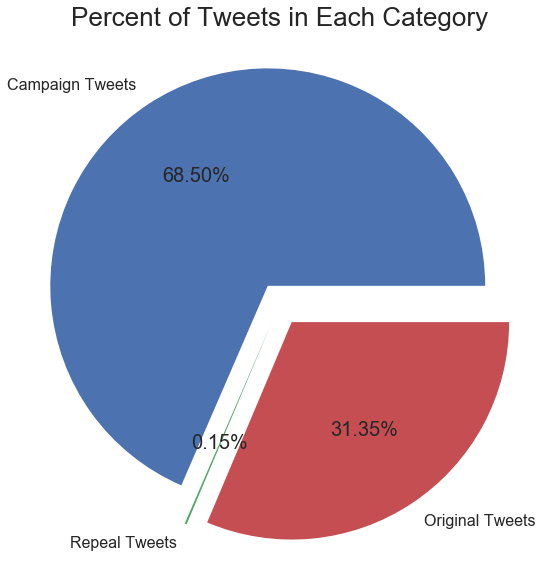

In [305]:
# For my final dataset, what was the breakdown between these three categories?
total_tweets = campaign_tweets_df['fullname'].count() + repeal_tweets_df['fullname'].count() + original_tweets_df['fullname'].count()
percentages = [str(campaign_tweets_df['fullname'].count()/total_tweets), str(repeal_tweets_df['fullname'].count()/total_tweets), \
         str(original_tweets_df['fullname'].count()/total_tweets)]

plt.subplots(figsize=(10,10))
plt.axes(aspect='equal')
plt.pie([campaign_tweets_df['fullname'].count(), repeal_tweets_df['fullname'].count(), \
         original_tweets_df['fullname'].count()], explode=[.1, .1 , .1], \
        labels=['Campaign Tweets', 'Repeal Tweets', 'Original Tweets'], autopct='%3.2f%%')
plt.title('Percent of Tweets in Each Category', {'fontsize': 26})
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26) 
plt.show()

In [112]:
mega_df['retweets'].describe()

count    419343.000000
mean          4.391949
std         304.453924
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      165604.000000
Name: retweets, dtype: float64

In [113]:
# Count of retweets with outliers removed

retweets_outliers_rmv = eda.remove_outliers(mega_df, 'retweets')

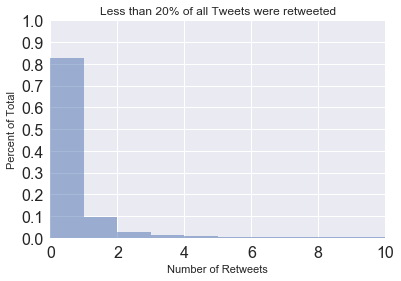

In [114]:
ticks = np.linspace(0,1, 11)

plt.hist(retweets_outliers_rmv, alpha=.5, bins = retweets_outliers_rmv.max(), normed=True)
plt.xlabel('Number of Retweets')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 20% of all Tweets were retweeted')
plt.xlim(0,10)
plt.show()

In [115]:
# Count of likes with outliers removed

likes_outliers_rmv = eda.remove_outliers(mega_df, 'likes')

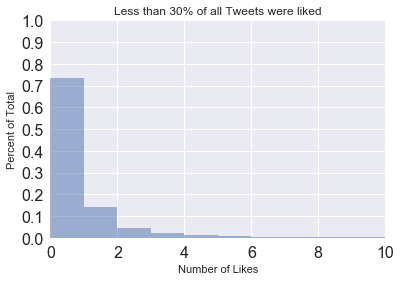

In [116]:
ticks = np.linspace(0,1, 11)

plt.hist(likes_outliers_rmv, alpha=.5, bins = likes_outliers_rmv.max(), normed=True)
plt.xlabel('Number of Likes')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 30% of all Tweets were liked')
plt.xlim(0,10)
plt.show()

In [117]:
# Count of replies with outliers removed

replies_outliers_rmv = eda.remove_outliers(mega_df, 'replies')

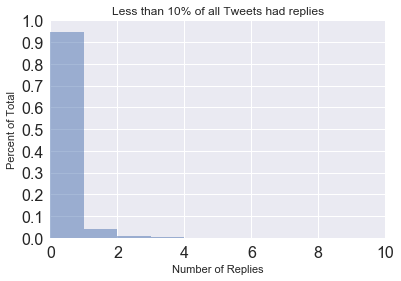

In [118]:
ticks = np.linspace(0,1, 11)

plt.hist(replies_outliers_rmv, bins = replies_outliers_rmv.max(), alpha=.5, normed=True)
plt.xlabel('Number of Replies')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 10% of all Tweets had replies')
plt.xlim(0,10)
plt.show()

## Time to compare the different categories

In [283]:
# Original tweets

orig_retweets_outliers_rmv = eda.remove_outliers(original_tweets_df, 'retweets')

orig_likes_outliers_rmv = eda.remove_outliers(original_tweets_df, 'likes')

orig_replies_outliers_rmv = eda.remove_outliers(original_tweets_df, 'replies')

In [284]:
# Campaign tweets

campaign_retweets_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'retweets')

campaign_likes_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'likes')

campaign_replies_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'replies')

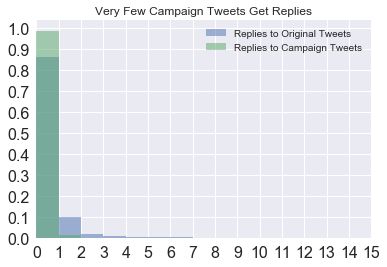

In [218]:
ticks = np.linspace(0,1, 11)
xticks = np.arange(16) 
bins_x = orig_replies_outliers_rmv.max()
bins_y = campaign_replies_outliers_rmv.max()

x = orig_replies_outliers_rmv
y = campaign_replies_outliers_rmv

plt.hist(x, alpha=0.5, bins=bins_x, label='Replies to Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Replies to Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('Very Few Campaign Tweets Get Replies')
plt.show()

In [267]:
original_tweets_df['replies'].max()

13.94822110811987

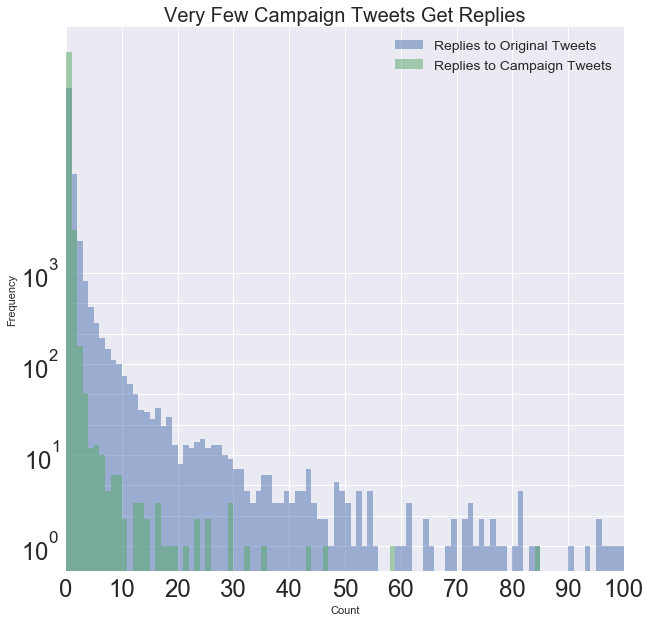

In [316]:
ticks = np.logspace(0,3, 10)
xticks = np.arange(0, 101, 10) 
bins_x = original_tweets_df['replies'].max()
bins_y = campaign_tweets_df['replies'].max()

x = original_tweets_df['replies']
y = campaign_tweets_df['replies']

plt.subplots(figsize=(10,10))
plt.hist(x, log='y', alpha=0.5, bins=bins_x, label='Replies to Original Tweets')
plt.hist(y, log='y', alpha=0.5, bins=bins_y, label='Replies to Campaign Tweets')
plt.yticks(ticks)
plt.xticks(xticks)
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.legend(loc='upper right', fontsize='x-small')
plt.title('Very Few Campaign Tweets Get Replies', {'fontsize': 20})
plt.show()

0     106761
1      12310
2       2255
3        816
4        422
5        285
6        192
7        145
8        110
9        100
10        74
11        61
12        47
16        33
13        31
14        30
18        26
15        25
17        21
24        15
23        14
19        13
21        13
26        13
27        13
22        12
25        12
28        10
29         9
20         8
30         7
31         7
Name: replies, dtype: int64

I hypothesize that people can tell what is real and what is a campaign and they are much more likely to engage in organic conversations by replying.
# Change y axis to log scale

In [122]:
original_replies = (original_tweets_df[original_tweets_df['replies'] != 0]['fullname'].count() / len(original_tweets_df['replies'])) * 100
campaign_replies = (campaign_tweets_df[campaign_tweets_df['replies'] != 0]['fullname'].count() / len(campaign_tweets_df['replies'])) * 100

print('Of all original tweets in the data, {:0.2f}% had a reply.'.format(original_replies))
print('Of all campaign tweets in the data, {:0.2f}% had a reply.'.format(campaign_replies))

Of all original tweets in the data, 13.95% had a reply.
Of all campaign tweets in the data, 1.21% had a reply.


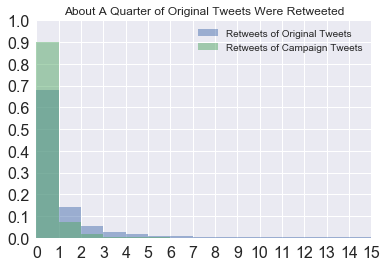

In [176]:
ticks = np.linspace(0,1, 11)
xticks = np.arange(16) 
bins_x = orig_retweets_outliers_rmv.max()
bins_y = campaign_retweets_outliers_rmv.max()
x = orig_retweets_outliers_rmv
y = campaign_retweets_outliers_rmv

plt.hist(x, alpha=0.5, bins=bins_x, label='Retweets of Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Retweets of Campaign Tweets', normed=1)

plt.yticks(ticks)
plt.xlim(0, 15)
plt.xticks(xticks)
plt.legend(loc='upper right')
plt.title('About A Quarter of Original Tweets Were Retweeted')
plt.show()

In [279]:
orig_retweets_outliers_rmv.max()

660

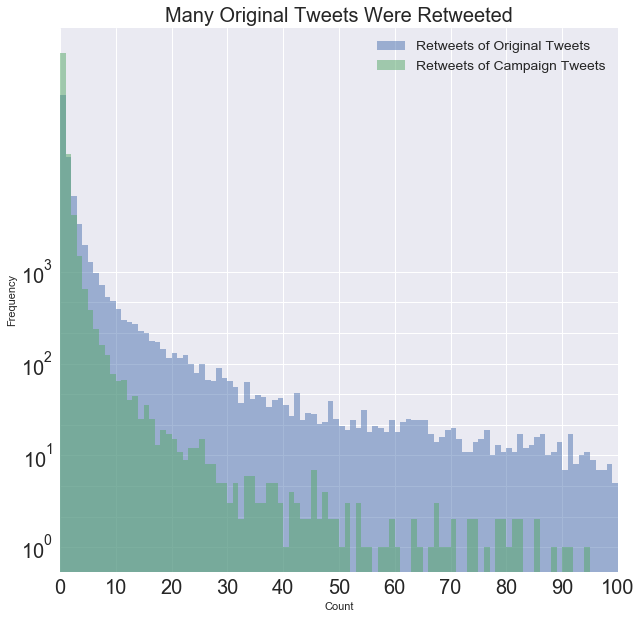

In [315]:
ticks = np.logspace(0,3, 10)
xticks = np.arange(0, 101, 10) 
bins_x = orig_retweets_outliers_rmv.max()
bins_y = campaign_retweets_outliers_rmv.max()

x = orig_retweets_outliers_rmv
y = campaign_retweets_outliers_rmv

plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(10,10))
plt.hist(x, log='y', alpha=0.5, bins=bins_x, label='Retweets of Original Tweets')
plt.hist(y, log='y', alpha=0.5, bins=bins_y, label='Retweets of Campaign Tweets')
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlim(0, 100)
plt.legend(loc='upper right', fontsize='x-small')
plt.title('Many Original Tweets Were Retweeted', {'fontsize': 20})
plt.show()

# original_retweets = (original_tweets_df[original_tweets_df['retweets'] != 0]['fullname'].count() / len(original_tweets_df['retweets'])) * 100
campaign_retweets = (campaign_tweets_df[campaign_tweets_df['retweets'] != 0]['fullname'].count() / len(campaign_tweets_df['retweets'])) * 100

print('Of all original tweets in the data, {:0.2f}% were retweeted.'.format(original_retweets))
print('Of all campaign tweets in the data, {:0.2f}% were retweeted.'.format(campaign_retweets))

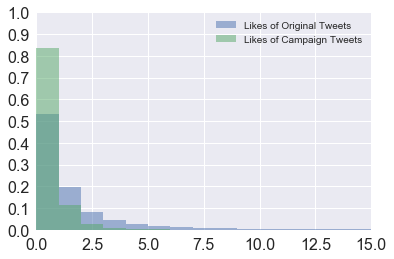

In [125]:
ticks = np.linspace(0,1, 11)
bins_x = orig_likes_outliers_rmv.max()
bins_y = campaign_likes_outliers_rmv.max()
x = orig_likes_outliers_rmv
y = campaign_likes_outliers_rmv

plt.hist(x, alpha=0.5, bins=bins_x, label='Likes of Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Likes of Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('')
plt.show()

In [126]:
original_likes = (original_tweets_df[original_tweets_df['likes'] != 0]['fullname'].count() / len(original_tweets_df['likes'])) * 100
campaign_likes = (campaign_tweets_df[campaign_tweets_df['likes'] != 0]['fullname'].count() / len(campaign_tweets_df['likes'])) * 100

print('Of all original tweets in the data, {:0.2f}% got likes.'.format(original_likes))
print('Of all campaign tweets in the data, {:0.2f}% got likes.'.format(campaign_likes))

Of all original tweets in the data, 46.90% got likes.
Of all campaign tweets in the data, 16.49% got likes.


## Start doing some NLP

In [ ]:
import spacy

nlp = spacy.load('en_core_web_md')

In [ ]:
def get_adj_lemmas(dataframe):
    lemma = []
    for doc in nlp.pipe(dataframe['cleaned_text'].astype('unicode').values, batch_size=50,
                            n_threads=3):
        if doc.is_parsed:
            lemma.append([n.lemma_ for n in doc if (n.pos_ == 'ADJ') & (n.lemma_ != '-PRON-')])
        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails
            lemma.append(None)

    dataframe['adj_lemmas'] = lemma
    return dataframe

In [ ]:
mega_df_1 = mega_df[:50000]
mega_df_2 = mega_df[50000:100000]
mega_df_3 = mega_df[100000:150000]
mega_df_4 = mega_df[150000:200000]
mega_df_5 = mega_df[200000:250000]
mega_df_6 = mega_df[250000:300000]
mega_df_7 = mega_df[300000:350000]
mega_df_8 = mega_df[350000:400000]
mega_df_9 = mega_df[400000:]

slice_list = [mega_df_1, mega_df_2, mega_df_3, mega_df_4, mega_df_5, mega_df_6, mega_df_7, mega_df_8, mega_df_9]

In [ ]:
# mega_df_1 = get_adj_lemmas(mega_df_1)
# mega_df_2 = get_adj_lemmas(mega_df_2)
# mega_df_3 = get_adj_lemmas(mega_df_3)
# mega_df_4 = get_adj_lemmas(mega_df_4)
# mega_df_5 = get_adj_lemmas(mega_df_5)
# mega_df_6 = get_adj_lemmas(mega_df_6)
# mega_df_7 = get_adj_lemmas(mega_df_7)
# mega_df_8 = get_adj_lemmas(mega_df_8)
# mega_df_9 = get_adj_lemmas(mega_df_9)

# mega_df_final = pd.concat([mega_df_1, mega_df_2, mega_df_3, mega_df_4, mega_df_5, mega_df_6, mega_df_7, mega_df_8, \
#                           mega_df_9], ignore_index=True)

In [ ]:
# mega_df_final.to_json('./mega_df_final.json')

In [128]:
mega_df_final = pd.read_json('mega_df_final.json')
mega_df_final = mega_df_final.sort_index(axis=0)

In [328]:
mega_df_final[mega_df_final['adj_lemmas'] != 0]

,@s,adj_lemmas,cleaned_text,fullname,id,info_campaign,likes,links,original_tweet,other_hashtags,pro_repeal,replies,retweets,text,timestamp,url,user
0,[@senpatroberts],"[net, small]",killing net neutrality is killing small business,Jake Suellentrop,935297188426649600,0,0,[],0,[],0,0,0,@SenPatRoberts Killing net neutrality is killi...,2017-11-28 00:00:01,/jakesuellentrop/status/935297188426649600,jakesuellentrop
1,[],"[which, that, bad]",affects the internet which affects everyone th...,Jim McGrath,935297192302059520,0,0,[https://www.battleforthenet.com/],1,[],0,0,0,"#NetNeutrality affects the internet, which aff...",2017-11-28 00:00:02,/FrDougal9000/status/935297192302059520,FrDougal9000
2,[],[],is an issue too,Kevin C. Bell,935297193484754944,0,0,[],1,"[#iot, #5g]",0,0,0,> #NetNeutrality is an #IoT & #5G issue too -h...,2017-11-28 00:00:02,/Kevin_C_Bell/status/935297193484754945,Kevin_C_Bell
3,[@fcc],[],so the wont let me beor let me be me so let m...,Matan Karasov,935297194730586112,0,0,[],1,[],0,0,0,"So the @FCC won't let me be\nOr let me be me, ...",2017-11-28 00:00:02,/MKarasov/status/935297194730586112,MKarasov
4,[],[net],call the fcc to fight net neutrality repeal he...,Robert Greenwald,935297198170009600,0,1,[http://bit.ly/2nacw4x],0,"[#fcc, #internet]",0,0,0,Call the FCC to fight net neutrality repeal! H...,2017-11-28 00:00:03,/robertgreenwald/status/935297198170009600,robertgreenwald
5,[],[average],repealing is just another handout to corporat...,Tulsi Gabbard,935297198274830336,0,1521,[],0,[],0,59,819,Repealing #NetNeutrality is just another hando...,2017-11-28 00:00:03,/TulsiGabbard/status/935297198274830336,TulsiGabbard
6,[],"[digital, small]",revoking would further the digital divide acr...,Kamala Harris,935297210597691392,0,3739,[],0,[],0,99,1854,Revoking #NetNeutrality would further the digi...,2017-11-28 00:00:06,/KamalaHarris/status/935297210597691397,KamalaHarris
7,[],[net],call the fcc to fight net neutrality repeal he...,Brave New Films,935297212795576320,0,2,[http://bit.ly/2nacw4x],0,"[#fcc, #internet]",0,0,3,Call the FCC to fight net neutrality repeal! H...,2017-11-28 00:00:07,/bravenewfilms/status/935297212795576320,bravenewfilms
8,[],[],pictwittercomywpxwhbekw,Tis The Season to be Queen 🎄,935297253710946304,0,7,[],1,[],0,0,6,#NetNeutrality pic.twitter.com/YWPXWhbEKW,2017-11-28 00:00:16,/ZekZebZab/status/935297253710946317,ZekZebZab
9,[],"[high, favourite, more]",a higher price to bingewatch your favourite se...,Metro News Canada,935297254361124864,0,7,[http://ow.ly/jx6z30gr0d5],1,[],0,2,9,A higher price to binge-watch your favourite s...,2017-11-28 00:00:17,/MetroNewsCanada/status/935297254361124864,MetroNewsCanada


## For each day recorded, what percent of tweets were original vs campaign?

In [185]:
mega_df_by_date = mega_df_final[mega_df_final['timestamp'] < '2017-12-14 00:00:00'].set_index("timestamp")
mega_df_by_date = mega_df_by_date.resample("D").sum()

In [209]:
month =  mega_df_by_date.index.month
day =  mega_df_by_date.index.day
date_list = []
for x in zip(mega_df_by_date.index.month, mega_df_by_date.index.day):
    date_list.append('{}-{}'.format(x[0], x[1]))
    
print(date_list)

['11-28', '11-29', '11-30', '12-1', '12-2', '12-3', '12-4', '12-5', '12-6', '12-7', '12-8', '12-9', '12-10', '12-11', '12-12', '12-13']


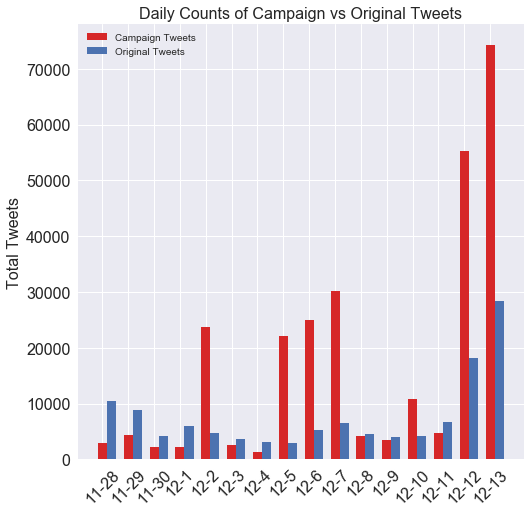

In [211]:
N = len(mega_df_by_date.index)
campaigns = mega_df_by_date['info_campaign']
originals = mega_df_by_date['original_tweet']
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size': 20})

p1 = plt.bar(ind, campaigns, width, color='#d62728')
p2 = plt.bar(ind + width, originals, width)

plt.ylabel('Total Tweets', fontsize=16)
plt.title('Daily Counts of Campaign vs Original Tweets', {'fontsize': 16})
plt.xticks(ind, (date_list), rotation=45)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Campaign Tweets', 'Original Tweets'))

plt.show()

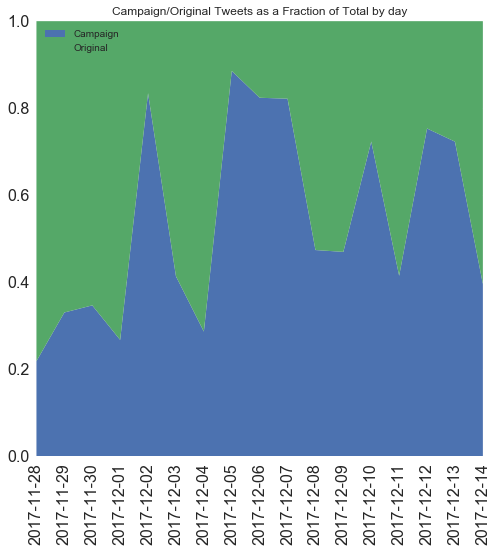

In [131]:
# Make data
data = pd.DataFrame({'Campaign Tweets':mega_df_by_date['info_campaign'], 'Original Tweets':mega_df_by_date['original_tweet']})
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)

N = len(mega_df_by_date.index)
ind = np.arange(N)    # the x locations for the groups

# Make the plot
plt.subplots(figsize=(8,8))

plt.stackplot(ind, data_perc['Campaign Tweets'],  data_perc['Original Tweets'], labels=['Campaign','Original'], cmap='Pastel1')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.xticks(ind, (mega_df_by_date.index.date), rotation=90)

plt.title('Campaign/Original Tweets as a Fraction of Total by day')
plt.show()


## Look at some adjectives

In [132]:
update_campaign_tweets_df = mega_df_final[mega_df_final['info_campaign'] == 1].drop_duplicates(subset='text')
update_original_tweets_df = mega_df_final[mega_df_final['original_tweet'] == 1]

In [133]:
from collections import Counter

original_adj_counter = Counter()
ignore_list = ['net', 'that', 'more', 'many', 'able', 'much', 'which', '“']

for adjs in update_original_tweets_df['adj_lemmas']:
    if (len(adjs) != 0):
        for adj in adjs:
            if adj not in ignore_list:
                original_adj_counter[adj] += 1

In [134]:
campaign_adj_counter = Counter()
ignore_list = ['net', 'that', 'more', 'many', 'able', 'much', 'which', 'fccs', 'monthsnapchat', 'powerfulinternetproviderslike', 'thiscontact']

for adjs in update_campaign_tweets_df['adj_lemmas']:
    if (len(adj) != 0):
        for adj in adjs:
            if adj not in ignore_list:
                campaign_adj_counter[adj] += 1

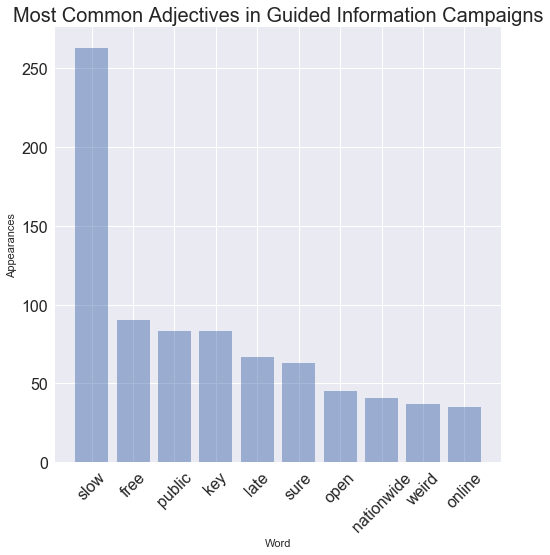

In [307]:
counts = dict(campaign_adj_counter.most_common(10))

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.subplots(figsize=(8,8))
plt.bar(indexes, values, alpha=.5)
plt.xticks(rotation=45)

# add labels
plt.rcParams.update({'font.size': 16})
plt.xticks(indexes, labels)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.title('Most Common Adjectives in Guided Information Campaigns',  {'fontsize': 20})
plt.ylabel('Appearances')
plt.xlabel('Word')
plt.show()

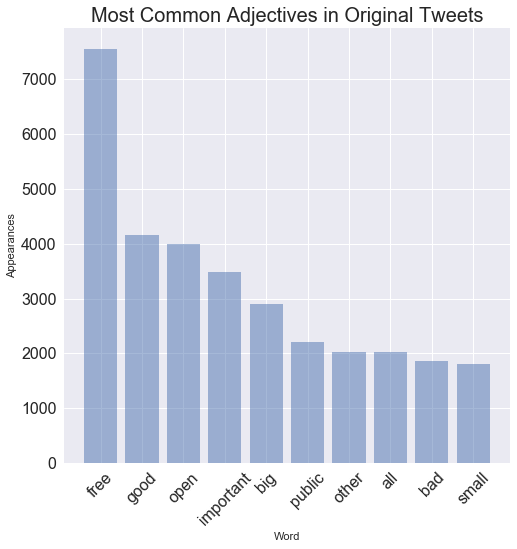

In [308]:
counts = dict(original_adj_counter.most_common(10))

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.subplots(figsize=(8,8))
plt.bar(indexes, values, alpha=.5)
plt.xticks(rotation=45)

# add labels
plt.xticks(indexes, labels, rotation=45)
plt.title('Most Common Adjectives in Original Tweets', {'fontsize': 20})
plt.ylabel('Appearances')
plt.xlabel('Word')
plt.show()

## Getting prepped to make a force-directed graph of @s
#### First, get a set of all @s done
#### Find every n=2 permutation of those that show up in tweets done
#### Remove dupes done
#### Get a count done
#### Get them formatted like the d3 graph will need

In [ ]:
# Create a list of every 2-item combo of mentions found in tweets in the data.
flat_list = eda.combos_of_ats(mega_df_final)

# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array = eda.alpha_tuples(flat_list)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df = eda.create_grouped_source_target(alpha_array)

In [ ]:
# Restrict this to only pairs that showed up 10 times or more. The graph won't be interpretable otherwise, and this is
# a good threshold for determining whether or not accounts were mentioned together frequenlty enough to matter.
grouped_source_target_df = grouped_source_target_df[grouped_source_target_df['count'] > 9]

In [ ]:
# Create an index of all the unique mentions in the data.
unique_ats = pd.Index(grouped_source_target_df['source']
                      .append(grouped_source_target_df['target'])
                      .reset_index(drop=True).unique())

In [ ]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list = eda.create_links_list(grouped_source_target_df, unique_ats)

# Create a list of every node
nodes_list = eda.create_nodes_list(unique_ats)

In [ ]:
# Create this as a NetworkX graph object so I can do some community detection
G = nx.Graph()

# Add nodes to the graph
for node in nodes_list:
    G.add_node(node['index'], name=node['name'])

# Add links to the graph
for link in links_list:
    G.add_edge(link['source'], link['target'], weight=link['value'])

In [ ]:
# Create optimized communities using Louvain modularity
communities = community.best_partition(G, partition=None, weight='weight', resolution=1.0, randomize=False)

In [ ]:
# Add community numbers to the nodes
for idx, group in enumerate(communities.values()):
    nodes_list[idx]['group'] = group

In [ ]:
json_prep = {"nodes":nodes_list, "links":links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

filename_out = 'nodes_edges.json'
json_out = open(filename_out,'w')
json_out.write(json_dump)
json_out.close()

In [ ]:
bc_dict = nx.betweenness_centrality(G, weight='weight')
sorted_bc_tups = sorted(bc_dict.items(), key=operator.itemgetter(1), reverse=True)

### Remove highest betweened node and redo the graph to see if other communities come up

In [ ]:
# Create a list of every 2-item combo of mentions found in tweets in the data that DO NOT include the node with
# highest betweenness centrality ('@ajitpaifcc').

flat_list_one_removed = []

for item in flat_list:
    if nodes_list[sorted_bc_tups[0][0]]['name'] not in item:
        flat_list_one_removed.append(item)

In [ ]:
# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array_one_removed = eda.alpha_tuples(flat_list_one_removed)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df_one_removed = eda.create_grouped_source_target(alpha_array_one_removed)

In [ ]:
grouped_source_target_df_one_removed = grouped_source_target_df_one_removed[grouped_source_target_df_one_removed['count'] > 8]

In [ ]:
# Create an index of all the unique mentions in the data.
unique_ats_one_removed = pd.Index(grouped_source_target_df_one_removed['source']
                      .append(grouped_source_target_df_one_removed['target'])
                      .reset_index(drop=True).unique())

In [ ]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list_one_removed = eda.create_links_list(grouped_source_target_df_one_removed, unique_ats_one_removed)

# Create a list of every node
nodes_list_one_removed = eda.create_nodes_list(unique_ats_one_removed)

In [ ]:
G_one_removed = nx.Graph()

In [ ]:
for node in nodes_list_one_removed:
    G_one_removed.add_node(node['index'], name=node['name'])

In [ ]:
for link in links_list_one_removed:
    G_one_removed.add_edge(link['source'], link['target'], weight=link['value'])

In [ ]:
communities_one_removed = community.best_partition(G_one_removed, partition=None, weight='weight', resolution=1.0, randomize=False)

In [ ]:
for idx, group in enumerate(communities_one_removed.values()):
    nodes_list_one_removed[idx]['group'] = group

In [ ]:
json_prep_removed = {"nodes":nodes_list_one_removed, "links":links_list_one_removed}
json_dump_removed = json.dumps(json_prep_removed, indent=1, sort_keys=True)

filename_out = 'nodes_edges_one_removed.json'
json_out = open(filename_out,'w')
json_out.write(json_dump_removed)
json_out.close()

### Remove second highest betweened node and redo the graph to see if other communities come up

In [ ]:
# Create a list of every 2-item combo of mentions found in tweets in the data that DO NOT include the two nodes with
# highest betweenness centrality ('@ajitpaifcc').

flat_list_two_removed = []

for item in flat_list:
    if (nodes_list[sorted_bc_tups[0][0]]['name'] not in item) & (nodes_list[sorted_bc_tups[1][0]]['name'] not in item):
        flat_list_two_removed.append(item)

In [ ]:
# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array_two_removed = eda.alpha_tuples(flat_list_two_removed)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df_two_removed = eda.create_grouped_source_target(alpha_array_two_removed)

In [ ]:
grouped_source_target_df_two_removed = grouped_source_target_df_two_removed[grouped_source_target_df_two_removed['count'] > 8]

In [ ]:
# Create an index of all the unique mentions in the data.
unique_ats_two_removed = pd.Index(grouped_source_target_df_two_removed['source']
                      .append(grouped_source_target_df_two_removed['target'])
                      .reset_index(drop=True).unique())

In [ ]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list_two_removed = eda.create_links_list(grouped_source_target_df_two_removed, unique_ats_two_removed)

# Create a list of every node
nodes_list_two_removed = eda.create_nodes_list(unique_ats_two_removed)

In [ ]:
G_two_removed = nx.Graph()

In [ ]:
for node in nodes_list_two_removed:
    G_two_removed.add_node(node['index'], name=node['name'])

In [ ]:
for link in links_list_two_removed:
    G_two_removed.add_edge(link['source'], link['target'], weight=link['value'])

In [ ]:
communities_two_removed = community.best_partition(G_two_removed, partition=None, weight='weight', resolution=1.0, randomize=False)

In [ ]:
for idx, group in enumerate(communities_two_removed.values()):
    nodes_list_two_removed[idx]['group'] = group

In [ ]:
json_prep_2_removed = {"nodes":nodes_list_two_removed, "links":links_list_two_removed}
json_dump_2_removed = json.dumps(json_prep_2_removed, indent=1, sort_keys=True)

filename_out = 'nodes_edges_two_removed.json'
json_out = open(filename_out,'w')
json_out.write(json_dump_2_removed)
json_out.close()

Pick a time window (12 hours is probably good) and determine the probabilities on a gamma distro of each user showing up over that period (will need to use Bayesian modeling to update priors). Set a threshold above which I will consider something to be showing up more than expected. When this happens, look at the communities that are being detected.

In [3]:
# Create an array of all unique users that are mentioned in tweets.

mentioned_set = set()

for item in mega_df_final['@s']:
    for name in item:
        mentioned_set.add(name)
        

In [4]:
at_table_list_of_lists = []

for idx, item in enumerate(mega_df_final['@s']):
    for at in item:
        at_table_list_of_lists.append([at, mega_df_final.iloc[idx]['timestamp']])

In [5]:
headers = ['users', 'timestamp']
at_df = pd.DataFrame(at_table_list_of_lists, columns=headers)

In [34]:
from datetime import date, datetime, timedelta

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_ranges = []        
for result in perdelta(datetime(2017, 11, 28, 12, 0, 0), datetime(2017, 12, 15, 12, 0, 0), timedelta(hours=12)):
     time_ranges.append(result)

In [43]:
# for idx, time in enumerate(at_df['timestamp'][:10]):
#     if time < time_ranges[1]:
#         at_df['end_ts'] = time_ranges[1]

slice_1_ats = at_df[at_df['timestamp'] < time_ranges[0]]
slice_2_ats = at_df[(at_df['timestamp'] >= time_ranges[0]) & (at_df['timestamp'] < time_ranges[1])]
slice_3_ats = at_df[(at_df['timestamp'] >= time_ranges[1]) & (at_df['timestamp'] < time_ranges[2])]
slice_4_ats = at_df[(at_df['timestamp'] >= time_ranges[2]) & (at_df['timestamp'] < time_ranges[3])]
slice_5_ats = at_df[(at_df['timestamp'] >= time_ranges[3]) & (at_df['timestamp'] < time_ranges[4])]
slice_6_ats = at_df[(at_df['timestamp'] >= time_ranges[4]) & (at_df['timestamp'] < time_ranges[5])]
slice_7_ats = at_df[(at_df['timestamp'] >= time_ranges[5]) & (at_df['timestamp'] < time_ranges[6])]
slice_8_ats = at_df[(at_df['timestamp'] >= time_ranges[6]) & (at_df['timestamp'] < time_ranges[7])]
slice_9_ats = at_df[(at_df['timestamp'] >= time_ranges[7]) & (at_df['timestamp'] < time_ranges[8])]
slice_10_ats = at_df[(at_df['timestamp'] >= time_ranges[8]) & (at_df['timestamp'] < time_ranges[9])]
slice_11_ats = at_df[(at_df['timestamp'] >= time_ranges[9]) & (at_df['timestamp'] < time_ranges[10])]
slice_12_ats = at_df[(at_df['timestamp'] >= time_ranges[10]) & (at_df['timestamp'] < time_ranges[11])]
slice_13_ats = at_df[(at_df['timestamp'] >= time_ranges[11]) & (at_df['timestamp'] < time_ranges[12])]
slice_14_ats = at_df[(at_df['timestamp'] >= time_ranges[12]) & (at_df['timestamp'] < time_ranges[13])]
slice_15_ats = at_df[(at_df['timestamp'] >= time_ranges[13]) & (at_df['timestamp'] < time_ranges[14])]
slice_16_ats = at_df[(at_df['timestamp'] >= time_ranges[14]) & (at_df['timestamp'] < time_ranges[15])]
slice_17_ats = at_df[(at_df['timestamp'] >= time_ranges[15]) & (at_df['timestamp'] < time_ranges[16])]
slice_18_ats = at_df[(at_df['timestamp'] >= time_ranges[16]) & (at_df['timestamp'] < time_ranges[17])]
slice_19_ats = at_df[(at_df['timestamp'] >= time_ranges[17]) & (at_df['timestamp'] < time_ranges[18])]
slice_20_ats = at_df[(at_df['timestamp'] >= time_ranges[18]) & (at_df['timestamp'] < time_ranges[19])]
slice_21_ats = at_df[(at_df['timestamp'] >= time_ranges[19]) & (at_df['timestamp'] < time_ranges[20])]
slice_22_ats = at_df[(at_df['timestamp'] >= time_ranges[20]) & (at_df['timestamp'] < time_ranges[21])]
slice_23_ats = at_df[(at_df['timestamp'] >= time_ranges[21]) & (at_df['timestamp'] < time_ranges[22])]
slice_24_ats = at_df[(at_df['timestamp'] >= time_ranges[22]) & (at_df['timestamp'] < time_ranges[23])]
slice_25_ats = at_df[(at_df['timestamp'] >= time_ranges[23]) & (at_df['timestamp'] < time_ranges[24])]
slice_26_ats = at_df[(at_df['timestamp'] >= time_ranges[24]) & (at_df['timestamp'] < time_ranges[25])]
slice_27_ats = at_df[(at_df['timestamp'] >= time_ranges[25]) & (at_df['timestamp'] < time_ranges[26])]
slice_28_ats = at_df[(at_df['timestamp'] >= time_ranges[26]) & (at_df['timestamp'] < time_ranges[27])]
slice_29_ats = at_df[(at_df['timestamp'] >= time_ranges[27]) & (at_df['timestamp'] < time_ranges[28])]
slice_30_ats = at_df[(at_df['timestamp'] >= time_ranges[28]) & (at_df['timestamp'] < time_ranges[29])]
slice_31_ats = at_df[(at_df['timestamp'] >= time_ranges[29]) & (at_df['timestamp'] < time_ranges[30])]
slice_32_ats = at_df[(at_df['timestamp'] >= time_ranges[30]) & (at_df['timestamp'] < time_ranges[31])]
slice_33_ats = at_df[(at_df['timestamp'] >= time_ranges[31]) & (at_df['timestamp'] < time_ranges[32])]
slice_34_ats = at_df[(at_df['timestamp'] >= time_ranges[32]) & (at_df['timestamp'] < time_ranges[33])]

In [69]:
time_ranges[33]

datetime.datetime(2017, 12, 15, 0, 0)

In [70]:
slice_1_ats['end_ts'] = time_ranges[0]
slice_2_ats['end_ts'] = time_ranges[1]
slice_3_ats['end_ts'] = time_ranges[2]
slice_4_ats['end_ts'] = time_ranges[3]
slice_5_ats['end_ts'] = time_ranges[4]
slice_6_ats['end_ts'] = time_ranges[5]
slice_7_ats['end_ts'] = time_ranges[6]
slice_8_ats['end_ts'] = time_ranges[7]
slice_9_ats['end_ts'] = time_ranges[8]
slice_10_ats['end_ts'] = time_ranges[9]
slice_11_ats['end_ts'] = time_ranges[10]
slice_12_ats['end_ts'] = time_ranges[11]
slice_13_ats['end_ts'] = time_ranges[12]
slice_14_ats['end_ts'] = time_ranges[13]
slice_15_ats['end_ts'] = time_ranges[14]
slice_16_ats['end_ts'] = time_ranges[15]
slice_17_ats['end_ts'] = time_ranges[16]
slice_18_ats['end_ts'] = time_ranges[17]
slice_19_ats['end_ts'] = time_ranges[18]
slice_20_ats['end_ts'] = time_ranges[19]
slice_21_ats['end_ts'] = time_ranges[20]
slice_22_ats['end_ts'] = time_ranges[21]
slice_23_ats['end_ts'] = time_ranges[22]
slice_24_ats['end_ts'] = time_ranges[23]
slice_25_ats['end_ts'] = time_ranges[24]
slice_26_ats['end_ts'] = time_ranges[25]
slice_27_ats['end_ts'] = time_ranges[26]
slice_28_ats['end_ts'] = time_ranges[27]
slice_29_ats['end_ts'] = time_ranges[28]
slice_30_ats['end_ts'] = time_ranges[29]
slice_31_ats['end_ts'] = time_ranges[30]
slice_32_ats['end_ts'] = time_ranges[31]
slice_33_ats['end_ts'] = time_ranges[32]
slice_34_ats['end_ts'] = time_ranges[33]

/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [73]:
grouped_at_df = pd.concat([slice_1_ats, slice_2_ats, slice_3_ats, slice_4_ats, slice_5_ats, slice_6_ats, slice_7_ats,\
                          slice_8_ats, slice_9_ats, slice_10_ats, slice_11_ats, slice_12_ats, slice_13_ats, slice_14_ats,\
                          slice_15_ats, slice_16_ats, slice_17_ats, slice_18_ats, slice_19_ats, slice_20_ats, slice_21_ats,\
                          slice_22_ats, slice_23_ats, slice_24_ats, slice_25_ats, slice_26_ats, slice_27_ats, slice_28_ats,\
                          slice_29_ats, slice_30_ats, slice_31_ats, slice_32_ats, slice_33_ats, slice_34_ats])

In [76]:
grouped_at_df['end_ts'].unique()



array(['2017-11-28T12:00:00.000000000', '2017-11-29T00:00:00.000000000',
       '2017-11-29T12:00:00.000000000', '2017-11-30T00:00:00.000000000',
       '2017-11-30T12:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2017-12-01T12:00:00.000000000', '2017-12-02T00:00:00.000000000',
       '2017-12-02T12:00:00.000000000', '2017-12-03T00:00:00.000000000',
       '2017-12-03T12:00:00.000000000', '2017-12-04T00:00:00.000000000',
       '2017-12-04T12:00:00.000000000', '2017-12-05T00:00:00.000000000',
       '2017-12-06T00:00:00.000000000', '2017-12-06T12:00:00.000000000',
       '2017-12-07T00:00:00.000000000', '2017-12-07T12:00:00.000000000',
       '2017-12-08T00:00:00.000000000', '2017-12-08T12:00:00.000000000',
       '2017-12-09T00:00:00.000000000', '2017-12-09T12:00:00.000000000',
       '2017-12-10T00:00:00.000000000', '2017-12-10T12:00:00.000000000',
       '2017-12-11T00:00:00.000000000', '2017-12-11T12:00:00.000000000',
       '2017-12-12T00:00:00.000000000', '2017-12-12

In [82]:
grouped_at_df.groupby(['end_ts', 'users']).agg(['count'])

timestamp
                                         count
end_ts              users                     
2017-11-28 12:00:00 @4chan                   1
                    @7879881122              1
                    @7im                     1
                    @_cberger_               1
                    @abc                     2
                    @abpmajhatv              1
                    @ac360                   1
                    @aclu                    6
                    @adityakalra             1
                    @afrotribuneco           1
                    @aftunion                1
                    @agschneiderman          2
                    @airbnb                  1
                    @airtel_presence         7
                    @airtelindia             2
                    @aitcofficial            1
                    @ajiolife                1
                    @ajitpai                 2
                    @ajitpaifcc            376
                    @ajplus                  1
                    @aksharpathak            1
                    @akshaykumar             1
                    @alalibrary              1
                    @alysonstoner            1
                    @amandaseales            2
                    @amazon                  7
                    @ambertamblyn            1
                    @amchamhk                1
                    @amitshah                1
                    @amol_kulkarni1          1
...                                        ...
2017-12-15 00:00:00 @twittersafety           1
                    @txag                    3
                    @usasenate               1
                    @usbtsarmy               1
                    @usrealitycheck          1
                    @verge                   2
                    @verizon                20
                    @vh1                     1
                    @vicxoralt               1
                    @virginiafoxx            1
                    @vonage                  1
                    @votejakechapman         1
                    @washingtonpost          2
                    @wdtn                    1
                    @wdtnmarkallan           1
                    @wellsvillecsd           1
                    @whitehouse              3
                    @whoopigoldberg          1
                    @windows                 1
                    @wired                   1
                    @wsj                     1
                    @xataka                  1
                    @xfinity                 1
                    @xterra1_                1
                    @yahoo                   1
                    @youranoncentral         1
                    @youranonnews            1
                    @yourdnrec               1
                    @youtube                12
                    @zachhaller              1

[21898 rows x 1 columns]

In [ ]:
at_dataframe = pd.DataFrame(at_table_array, columns=['user','timestamp'])
grouped_at_df = at_dataframe.copy()

In [ ]:
grouped_at_df

In [ ]:
day_1_am_df = at_dataframe[(at_dataframe['timestamp'] > '2017-11-28 00:00:01') & (at_dataframe['timestamp'] < '2017-11-28 12:00:00')]
day_1_pm_df = mega_df_12h_slice.loc['2017-11-28 12:00:01':'2017-11-29 00:00:00']
day_2_am_df = mega_df_12h_slice.loc['2017-11-29 00:00:01':'2017-11-29 12:00:00']
day_2_pm_df = mega_df_12h_slice.loc['2017-11-29 12:00:01':'2017-11-30 00:00:00']
day_3_am_df = mega_df_12h_slice.loc['2017-11-30 00:00:01':'2017-11-30 12:00:00']
day_3_pm_df = mega_df_12h_slice.loc['2017-11-30 12:00:01':'2017-12-01 00:00:00']
day_4_am_df = mega_df_12h_slice.loc['2017-12-01 00:00:01':'2017-12-01 12:00:00']
day_4_pm_df = mega_df_12h_slice.loc['2017-12-01 12:00:01':'2017-12-02 00:00:00']
day_5_am_df = mega_df_12h_slice.loc['2017-12-02 00:00:01':'2017-12-02 12:00:00']
day_5_pm_df = mega_df_12h_slice.loc['2017-12-02 12:00:01':'2017-12-03 00:00:00']
day_6_am_df = mega_df_12h_slice.loc['2017-12-03 00:00:01':'2017-12-03 12:00:00']
day_6_pm_df = mega_df_12h_slice.loc['2017-12-03 12:00:01':'2017-12-04 00:00:00']
day_7_am_df = mega_df_12h_slice.loc['2017-12-04 00:00:01':'2017-12-04 12:00:00']
day_7_pm_df = mega_df_12h_slice.loc['2017-12-04 12:00:01':'2017-12-05 00:00:00']
day_8_am_df = mega_df_12h_slice.loc['2017-12-05 00:00:01':'2017-12-05 12:00:00']
day_8_pm_df = mega_df_12h_slice.loc['2017-12-05 12:00:01':'2017-12-06 00:00:00']
day_9_am_df = mega_df_12h_slice.loc['2017-12-06 00:00:01':'2017-12-06 12:00:00']
day_9_pm_df = mega_df_12h_slice.loc['2017-12-06 12:00:01':'2017-12-07 00:00:00']
day_10_am_df = mega_df_12h_slice.loc['2017-12-07 00:00:01':'2017-12-07 12:00:00']
day_10_pm_df = mega_df_12h_slice.loc['2017-12-07 12:00:01':'2017-12-08 00:00:00']
day_11_am_df = mega_df_12h_slice.loc['2017-12-08 00:00:01':'2017-12-08 12:00:00']
day_11_pm_df = mega_df_12h_slice.loc['2017-12-08 12:00:01':'2017-12-09 00:00:00']
day_12_am_df = mega_df_12h_slice.loc['2017-12-09 00:00:01':'2017-12-09 12:00:00']
day_12_pm_df = mega_df_12h_slice.loc['2017-12-09 12:00:01':'2017-12-10 00:00:00']
day_13_am_df = mega_df_12h_slice.loc['2017-12-10 00:00:01':'2017-12-10 12:00:00']
day_13_pm_df = mega_df_12h_slice.loc['2017-12-10 12:00:01':'2017-12-11 00:00:00']
day_14_am_df = mega_df_12h_slice.loc['2017-12-11 00:00:01':'2017-12-11 12:00:00']
day_14_pm_df = mega_df_12h_slice.loc['2017-12-11 12:00:01':'2017-12-12 00:00:00']
day_15_am_df = mega_df_12h_slice.loc['2017-12-12 00:00:01':'2017-12-12 12:00:00']
day_15_pm_df = mega_df_12h_slice.loc['2017-12-12 12:00:01':'2017-12-13 00:00:00']
day_16_am_df = mega_df_12h_slice.loc['2017-12-13 00:00:01':'2017-12-13 12:00:00']
day_16_pm_df = mega_df_12h_slice.loc['2017-12-13 12:00:01':'2017-12-14 00:00:00']
day_17_am_df = mega_df_12h_slice.loc['2017-12-14 00:00:01':'2017-12-14 12:00:00']
day_17_pm_df = mega_df_12h_slice.loc['2017-12-14 12:00:01':'2017-12-15 00:00:00']

In [ ]:
count_of_at_tweets = 0
for item in mega_df_final['@s']:
    if len(item) != 0:
        count_of_at_tweets += len(item)
        
count_of_at_tweets

In [ ]:
# Dataframe with each person who was mentioned and the timestamp that it happened (every single mention)

at_dataframe = pd.DataFrame(np.zeros((count_of_at_tweets, 2)), columns=['user', 'timestamp'])

In [ ]:
for idx, at in enumerate(mega_df_final['@s'][:20]):
    if len(at) != 0:
        for item in at:
            at_dataframe.iloc[i]['user'] = item
            at_dataframe.iloc[i]['timestamp'] = mega_df_final.iloc[idx]['timestamp']
            i += 1

In [ ]:
at_dataframe

In [ ]:
for idx, user in enumerate(at_dataframe['user']):
    at_dataframe.iloc[idx]['total_ats'] = Counter[user]
    at_dataframe.iloc[user]['timestamp'] = 

In [ ]:
mega_df_final

In [ ]:
## Slice the data up into 12 hour windows

In [ ]:
# Create a copy of the main dataframe. Figure out how many total days there are. Make the timestamp the index so these

mega_df_12h_slice = mega_df_final
num_days = len(mega_df_12h_slice['timestamp'].dt.day.unique())
mega_df_12h_slice = mega_df_12h_slice.set_index(['timestamp'])

In [ ]:
# ...but not too easily. Slice the dataframe into 12 hour windows manually.

day_1_am_df = mega_df_12h_slice.loc['2017-11-28 00:00:01':'2017-11-28 12:00:00']
day_1_pm_df = mega_df_12h_slice.loc['2017-11-28 12:00:01':'2017-11-29 00:00:00']
day_2_am_df = mega_df_12h_slice.loc['2017-11-29 00:00:01':'2017-11-29 12:00:00']
day_2_pm_df = mega_df_12h_slice.loc['2017-11-29 12:00:01':'2017-11-30 00:00:00']
day_3_am_df = mega_df_12h_slice.loc['2017-11-30 00:00:01':'2017-11-30 12:00:00']
day_3_pm_df = mega_df_12h_slice.loc['2017-11-30 12:00:01':'2017-12-01 00:00:00']
day_4_am_df = mega_df_12h_slice.loc['2017-12-01 00:00:01':'2017-12-01 12:00:00']
day_4_pm_df = mega_df_12h_slice.loc['2017-12-01 12:00:01':'2017-12-02 00:00:00']
day_5_am_df = mega_df_12h_slice.loc['2017-12-02 00:00:01':'2017-12-02 12:00:00']
day_5_pm_df = mega_df_12h_slice.loc['2017-12-02 12:00:01':'2017-12-03 00:00:00']
day_6_am_df = mega_df_12h_slice.loc['2017-12-03 00:00:01':'2017-12-03 12:00:00']
day_6_pm_df = mega_df_12h_slice.loc['2017-12-03 12:00:01':'2017-12-04 00:00:00']
day_7_am_df = mega_df_12h_slice.loc['2017-12-04 00:00:01':'2017-12-04 12:00:00']
day_7_pm_df = mega_df_12h_slice.loc['2017-12-04 12:00:01':'2017-12-05 00:00:00']
day_8_am_df = mega_df_12h_slice.loc['2017-12-05 00:00:01':'2017-12-05 12:00:00']
day_8_pm_df = mega_df_12h_slice.loc['2017-12-05 12:00:01':'2017-12-06 00:00:00']
day_9_am_df = mega_df_12h_slice.loc['2017-12-06 00:00:01':'2017-12-06 12:00:00']
day_9_pm_df = mega_df_12h_slice.loc['2017-12-06 12:00:01':'2017-12-07 00:00:00']
day_10_am_df = mega_df_12h_slice.loc['2017-12-07 00:00:01':'2017-12-07 12:00:00']
day_10_pm_df = mega_df_12h_slice.loc['2017-12-07 12:00:01':'2017-12-08 00:00:00']
day_11_am_df = mega_df_12h_slice.loc['2017-12-08 00:00:01':'2017-12-08 12:00:00']
day_11_pm_df = mega_df_12h_slice.loc['2017-12-08 12:00:01':'2017-12-09 00:00:00']
day_12_am_df = mega_df_12h_slice.loc['2017-12-09 00:00:01':'2017-12-09 12:00:00']
day_12_pm_df = mega_df_12h_slice.loc['2017-12-09 12:00:01':'2017-12-10 00:00:00']
day_13_am_df = mega_df_12h_slice.loc['2017-12-10 00:00:01':'2017-12-10 12:00:00']
day_13_pm_df = mega_df_12h_slice.loc['2017-12-10 12:00:01':'2017-12-11 00:00:00']
day_14_am_df = mega_df_12h_slice.loc['2017-12-11 00:00:01':'2017-12-11 12:00:00']
day_14_pm_df = mega_df_12h_slice.loc['2017-12-11 12:00:01':'2017-12-12 00:00:00']
day_15_am_df = mega_df_12h_slice.loc['2017-12-12 00:00:01':'2017-12-12 12:00:00']
day_15_pm_df = mega_df_12h_slice.loc['2017-12-12 12:00:01':'2017-12-13 00:00:00']
day_16_am_df = mega_df_12h_slice.loc['2017-12-13 00:00:01':'2017-12-13 12:00:00']
day_16_pm_df = mega_df_12h_slice.loc['2017-12-13 12:00:01':'2017-12-14 00:00:00']
day_17_am_df = mega_df_12h_slice.loc['2017-12-14 00:00:01':'2017-12-14 12:00:00']
day_17_pm_df = mega_df_12h_slice.loc['2017-12-14 12:00:01':'2017-12-15 00:00:00']

In [ ]:
# Confirming that this contains the same number of entries total as the original dataframe.

print(len(day_1_am_df['user']) + len(day_1_pm_df['user']) + len(day_2_am_df['user']) + len(day_2_pm_df['user']) \
+ len(day_3_am_df['user']) + len(day_3_pm_df['user']) + len(day_4_am_df['user']) + len(day_4_pm_df['user'])\
+ len(day_5_am_df['user']) + len(day_5_pm_df['user']) + len(day_6_am_df['user']) + len(day_6_pm_df['user'])\
+ len(day_7_am_df['user']) + len(day_7_pm_df['user']) + len(day_8_am_df['user']) + len(day_8_pm_df['user'])\
+ len(day_9_am_df['user']) + len(day_9_pm_df['user']) + len(day_10_am_df['user']) + len(day_10_pm_df['user'])\
+ len(day_11_am_df['user']) + len(day_11_pm_df['user']) + len(day_12_am_df['user']) + len(day_12_pm_df['user'])\
+ len(day_13_am_df['user']) + len(day_13_pm_df['user']) + len(day_14_am_df['user']) + len(day_14_pm_df['user'])\
+ len(day_15_am_df['user']) + len(day_15_pm_df['user']) + len(day_16_am_df['user']) + len(day_16_pm_df['user'])\
+ len(day_17_am_df['user']) + len(day_17_pm_df['user']))

print(len(mega_df_final['user']))

In [ ]:
# Create an array of all unique users that are mentioned in tweets.

mentioned_set = set()

for item in mega_df_final['@s']:
    for name in item:
        mentioned_set.add(name)
        
mentioned_array = np.array(list(mentioned_set))

In [ ]:
# Use the above array to create a dataframe of all unique users who are mentioned in tweets with a 'frequency' column
# to be filled in with the probability each user will be mentioned in any randomly selected tweet.

user_mention_freq_df = pd.DataFrame(mentioned_array, columns=['user'])
user_mention_freq_df['prob_of_appearing'] = pd.Series(np.zeros((len(mentioned_set), )))

In [ ]:
# Create a counter dictionary that tells us how many times every unique user was @d in a tweet.

at_counter = Counter()

for at in mega_df_final['@s']:
    for item in at:
        at_counter[item] += 1

In [ ]:
# Fill in the 'prob_of_appearing' column.

total_tweets = mega_df_final['text'].count()

for i, user in enumerate(user_mention_freq_df['user']):
    user_mention_freq_df.at[i, 'prob_of_appearing'] = (at_counter[user] / total_tweets)

In [ ]:
# Create a 'prob_12h_slice' column that has this value for each user (which will become lambda).

user_mention_freq_df['prob_12h_slice'] = user_mention_freq_df['prob_of_appearing'] / (num_days / (1/2))

In [ ]:
slice_df_list = [day_1_am_df
day_1_pm_df, day_2_am_df, day_2_pm_df, day_3_am_df, day_3_pm_df, day_4_am_df, day_4_pm_df,\
day_5_am_df, day_5_pm_df, day_6_am_df, day_6_pm_df, day_7_am_df, day_7_pm_df, day_8_am_df, day_8_pm_df, day_9_am_df,\
day_9_pm_df, day_10_am_df, day_10_pm_df, day_11_am_df, day_11_pm_df, day_12_am_df, day_12_pm_df, day_13_am_df,\
day_13_pm_df, day_14_am_df, day_14_pm_df, day_15_am_df, day_15_pm_df, day_16_am_df, day_16_pm_df, day_17_am_df, day_17_pm_df]

In [ ]:
for 

In [ ]:
list_of_at_counters = []

for slice_df in slice_df_list:
    at_counter = Counter()
    for at in slice_df['@s']:
        for item in at:
            at_counter[item] += 1
    list_of_at_counters.append(at_counter)
    
len(list_of_at_counters)

In [ ]:
for name in slice_df_list:
    print(str(name.))

In [ ]:
slice_df_list_text = [str(df)]

In [ ]:
# Correct poisson format: 2 = k, .1 = lambda

scipy.poisson.pmf(2, .1)

In [ ]:
new_columns = ['day_1_am_ats', 'day_1_am_ats_prob', 'day_1_pm_ats', 'day_1_pm_ats_prob',\
'day_2_am_ats', 'day_2_am_ats_prob', 'day_2_pm_ats', 'day_2_pm_ats_prob', 'day_3_am_ats', 'day_3_am_ats_prob', 'day_3_pm_ats',\
'day_3_pm_ats_prob', 'day_4_am_ats', 'day_4_am_ats_prob', 'day_4_pm_ats', 'day_4_pm_ats_prob', 'day_5_am_ats', 'day_5_am_ats_prob',\
'day_5_pm_ats', 'day_5_pm_ats_prob', 'day_6_am_ats', 'day_6_am_ats_prob', 'day_6_pm_ats', 'day_6_pm_ats_prob', 'day_7_am_ats',\
'day_7_am_ats_prob', 'day_7_pm_ats', 'day_7_pm_ats_prob', 'day_8_am_ats', 'day_8_am_ats_prob', 'day_8_pm_ats', 'day_8_pm_ats_prob',\
'day_9_am_ats', 'day_9_am_ats_prob', 'day_9_pm_ats', 'day_9_pm_ats_prob', 'day_10_am_ats', 'day_10_am_ats_prob',\
'day_10_pm_ats', 'day_10_pm_ats_prob', 'day_11_am_ats', 'day_11_am_ats_prob', 'day_11_pm_ats', 'day_11_pm_ats_prob',\
'day_12_am_ats', 'day_12_am_ats_prob', 'day_12_pm_ats', 'day_12_pm_ats_prob', 'day_13_am_ats', 'day_13_am_ats_prob',\
'day_13_pm_ats', 'day_13_pm_ats_prob', 'day_14_am_ats', 'day_14_am_ats_prob', 'day_14_pm_ats', 'day_14_pm_ats_prob',\
'day_15_am_ats', 'day_15_am_ats_prob', 'day_15_pm_ats', 'day_15_pm_ats_prob', 'day_16_am_ats', 'day_16_am_ats_prob',\
'day_16_pm_ats', 'day_16_pm_ats_prob', 'day_17_am_ats', 'day_17_am_ats_prob', 'day_17_pm_ats', 'day_17_pm_ats_prob']

In [ ]:
for name in new_columns:
    user_mention_freq_df[name] = 0.0

In [ ]:
for idx, user in enumerate(user_mention_freq_df['user']):
#     at_counter = Counter()
#     for at in mega_df_final['@s']:
#         for item in at:
#             at_counter[item] += 1
    for column in user_mention_freq_df.columns[3:71:2]:
        user_mention_freq_df.iloc[idx][column] = 0

In [ ]:
day_1_am_df
day_1_pm_df
day_2_am_df
day_2_pm_df
day_3_am_df
day_3_pm_df
day_4_am_df
day_4_pm_df
day_5_am_df
day_5_pm_df
day_6_am_df
day_6_pm_df
day_7_am_df
day_7_pm_df
day_8_am_df
day_8_pm_df
day_9_am_df
day_9_pm_df
day_10_am_df
day_10_pm_df
day_11_am_df
day_11_pm_df
day_12_am_df
day_12_pm_df
day_13_am_df
day_13_pm_df
day_14_am_df
day_14_pm_df
day_15_am_df
day_15_pm_df
day_16_am_df
day_16_pm_df
day_17_am_df
day_17_pm_df